In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analisis_cajas2(archivo_excel, sucursal, max_cajas=10, exportar=True):
    """
    Analiza y recomienda la cantidad de cajas por hora para una sucursal,
    usando estimaciones reales de capacidad de atenci√≥n por caja por d√≠a.

    Par√°metros:
    -----------
    archivo_excel :Ruta al archivo Excel con los datos.
    sucursal : Nombre de la sucursal a analizar.
    max_cajas :M√°ximo n√∫mero de cajas disponibles.
    exportar :

    Retorna:
    --------
    df_resultado_horario : Resultados con llegadas y cajas sugeridas por hora.
    """

    # Cargar y preparar datos
    df = pd.read_excel(archivo_excel)
    df['Fecha'] = pd.to_datetime(df['FechaID'].astype(str), format='%Y%m%d')
    df['Inicio'] = pd.to_datetime(df['TurnoHoraInicio'], format='%H:%M:%S')
    df['Fin'] = pd.to_datetime(df['TurnoHoraFin'], format='%H:%M:%S')
    df['Hora'] = df['Inicio'].dt.hour
    df['DiaSemana'] = df['Fecha'].dt.day_name()
    df['Duracion_horas'] = (df['Fin'] - df['Inicio']).dt.total_seconds() / 3600

    if sucursal not in df['Sucursal'].unique():
        raise ValueError(f"La sucursal '{sucursal}' no se encuentra en el archivo.")

    df_sucursal = df[df['Sucursal'] == sucursal].copy()

    # Estimar capacidad por d√≠a
    personas_por_caja_por_dia = {}
    for dia in df_sucursal['DiaSemana'].unique():
        df_dia = df_sucursal[df_sucursal['DiaSemana'] == dia]
        llegadas_por_turno = df_dia.groupby(['Fecha', 'Inicio']).size().reset_index(name='Llegadas')
        duracion_promedio = df_dia['Duracion_horas'].mean()
        if len(llegadas_por_turno) > 0 and duracion_promedio > 0:
            personas_por_caja = llegadas_por_turno['Llegadas'].sum() / (len(llegadas_por_turno) * duracion_promedio)
        else:
            personas_por_caja = 6  # valor por defecto
        personas_por_caja_por_dia[dia] = personas_por_caja

    # Recomendaciones por hora
    recomendaciones_horarias = []
    for dia in df_sucursal['DiaSemana'].unique():
        dias_filtrados = df_sucursal[df_sucursal['DiaSemana'] == dia]
        ultimos_cuatro_dias = dias_filtrados['Fecha'].drop_duplicates().sort_values(ascending=False).head(4)
        df_dia = dias_filtrados[dias_filtrados['Fecha'].isin(ultimos_cuatro_dias)].copy()

        df_dia['HoraCompleta'] = df_dia['Inicio'].dt.floor('h')
        llegadas_por_hora = df_dia.groupby(['Fecha', 'HoraCompleta']).size().reset_index(name='Llegadas')
        llegadas_por_hora['Hora'] = llegadas_por_hora['HoraCompleta'].dt.hour
        llegadas_por_hora['DiaSemana'] = dia

        resumen = llegadas_por_hora.groupby('Hora').agg({'Llegadas': 'mean'}).reindex(range(6, 21), fill_value=0)
        resumen['DiaSemana'] = dia
        resumen['Hora'] = resumen.index
        resumen['Capacidad'] = personas_por_caja_por_dia[dia]
        resumen['Cajas Sugeridas (m√°x 10)'] = np.ceil(resumen['Llegadas'] / resumen['Capacidad']).clip(upper=max_cajas).astype(int)

        recomendaciones_horarias.append(resumen)

    df_resultado_horario = pd.concat(recomendaciones_horarias).reset_index(drop=True)

    # Traducir d√≠as al espa√±ol
    dias_traducidos = {
        'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Mi√©rcoles',
        'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'S√°bado', 'Sunday': 'Domingo'
    }
    orden_dias_es = ['Lunes', 'Martes', 'Mi√©rcoles', 'Jueves', 'Viernes', 'S√°bado', 'Domingo']
    df_resultado_horario['DiaSemana'] = df_resultado_horario['DiaSemana'].map(dias_traducidos)
    df_resultado_horario['DiaSemana'] = pd.Categorical(df_resultado_horario['DiaSemana'],
                                                       categories=orden_dias_es,
                                                       ordered=True)
    df_resultado_horario = df_resultado_horario.sort_values(['DiaSemana', 'Hora'])

    # Gr√°fica 1: Heatmap
    df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (m√°x 10)'].mean().reset_index()
    pivot = df_pivot.pivot(index='Hora', columns='DiaSemana', values='Cajas Sugeridas (m√°x 10)')
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Cajas Sugeridas'})
    plt.title(f"Cajas Sugeridas por D√≠a y Hora en la sucursal {sucursal}")
    plt.xlabel("D√≠a de la Semana")
    plt.ylabel("Hora del D√≠a")
    plt.tight_layout()
    plt.show()

    # Gr√°fica 2: L√≠nea de llegadas promedio
    plt.figure(figsize=(14, 8))
    for dia in orden_dias_es:
        subset = df_resultado_horario[df_resultado_horario['DiaSemana'] == dia]
        if not subset.empty:
            plt.plot(subset['Hora'], subset['Llegadas'], marker='o', label=dia)

    plt.title(f'Promedio de Llegadas por Hora - Sucursal {sucursal}')
    plt.xlabel('Hora del D√≠a')
    plt.ylabel('N√∫mero Promedio de Llegadas')
    plt.xticks(range(6, 21))
    plt.legend(title='D√≠a de la Semana')
    plt.tight_layout()
    plt.show()

    # Exportar resultados
    if exportar:
        output_path = f"resultado_cajas_sucursal_{sucursal}.xlsx"
        df_resultado_horario.to_excel(output_path, index=False)
        print(f"Archivo guardado como: {output_path}")

    return df_resultado_horario


<ipython-input-34-b25bb7855108>:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (m√°x 10)'].mean().reset_index()


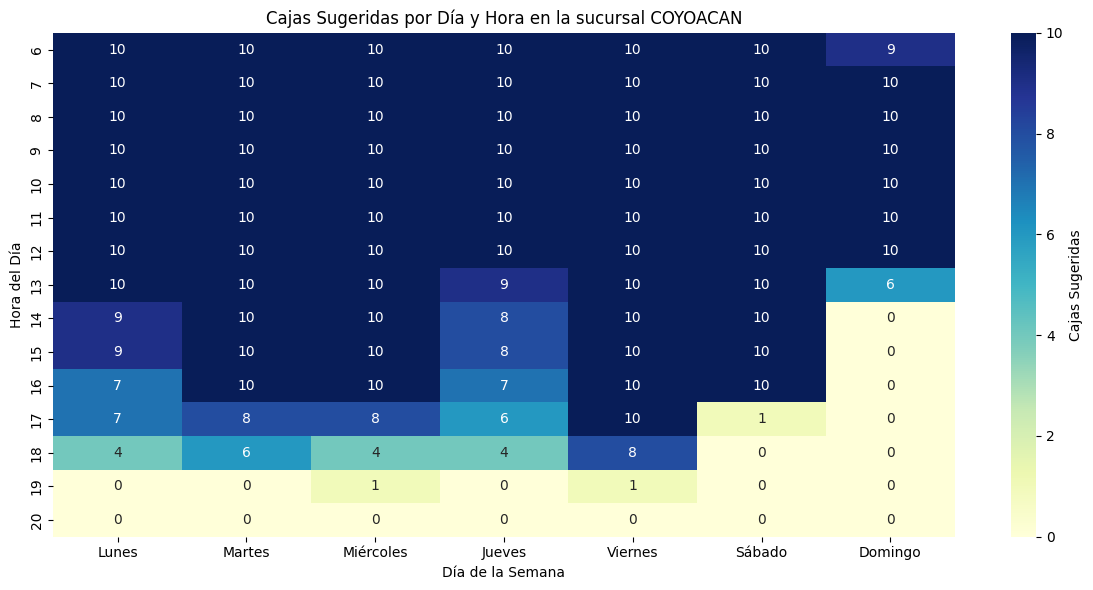

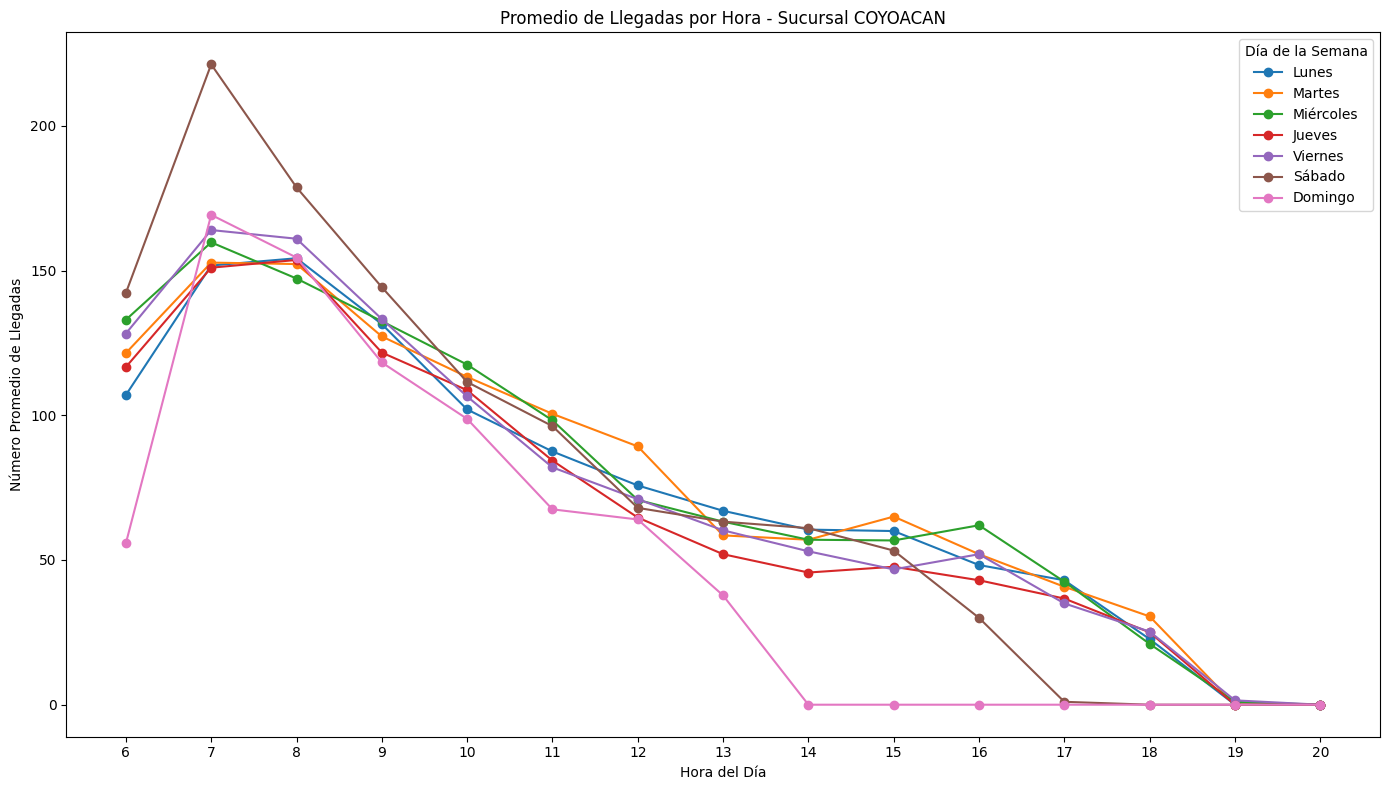

Archivo guardado como: resultado_cajas_sucursal_COYOACAN.xlsx


KeyError: 'Llegadas'

In [35]:
resultado = analisis_cajas2("Muestra Proyecto Socios Formadores.xlsx", sucursal="COYOACAN",max_cajas=10)

<ipython-input-26-24ffb3781dd5>:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (m√°x 10)'].mean().reset_index()


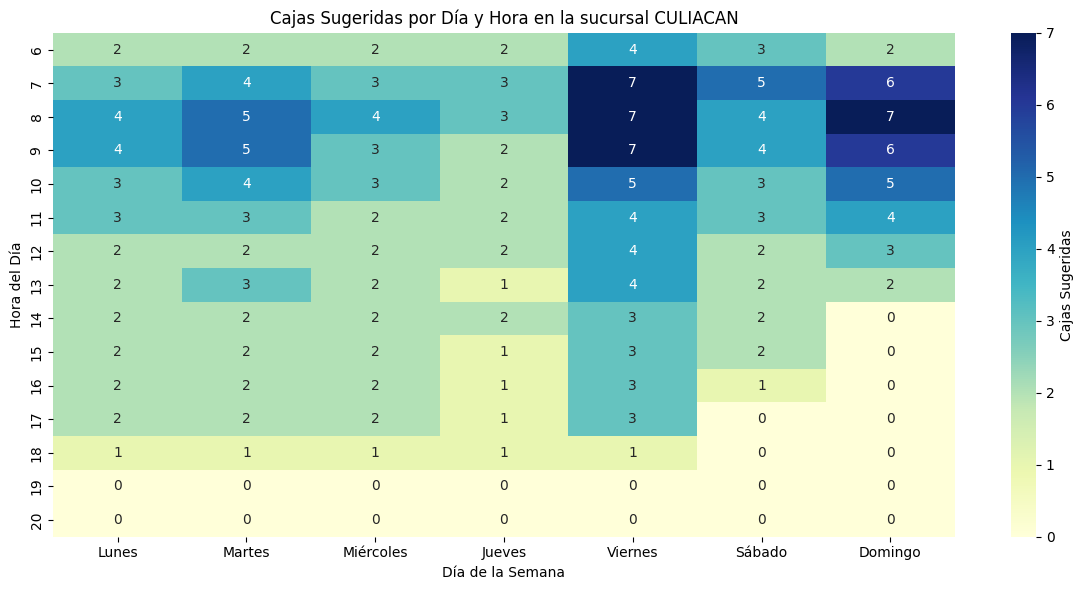

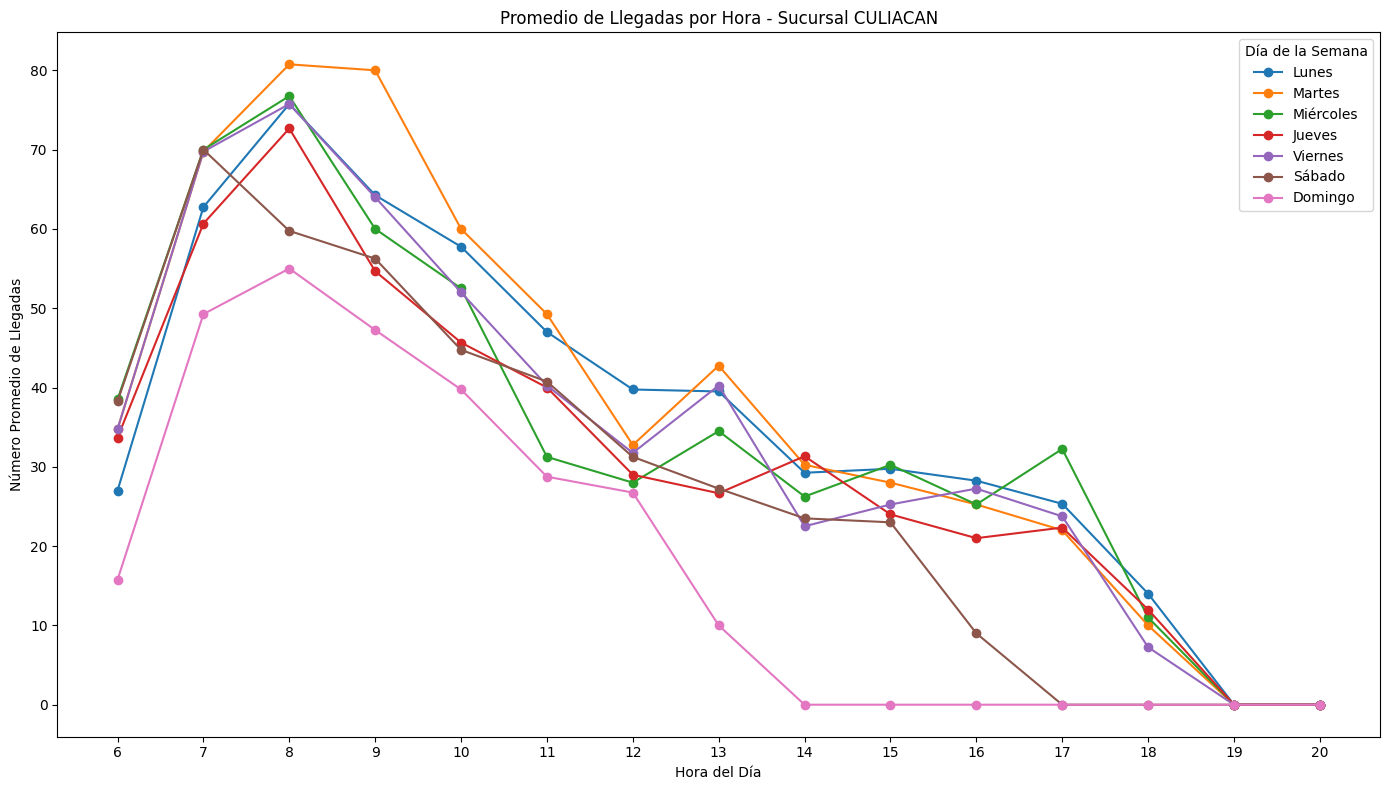

Archivo guardado como: resultado_cajas_sucursal_CULIACAN.xlsx


In [28]:
resultado = analisis_cajas2("Muestra Proyecto Socios Formadores.xlsx", sucursal="CULIACAN",max_cajas=7)

<ipython-input-26-24ffb3781dd5>:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (m√°x 10)'].mean().reset_index()


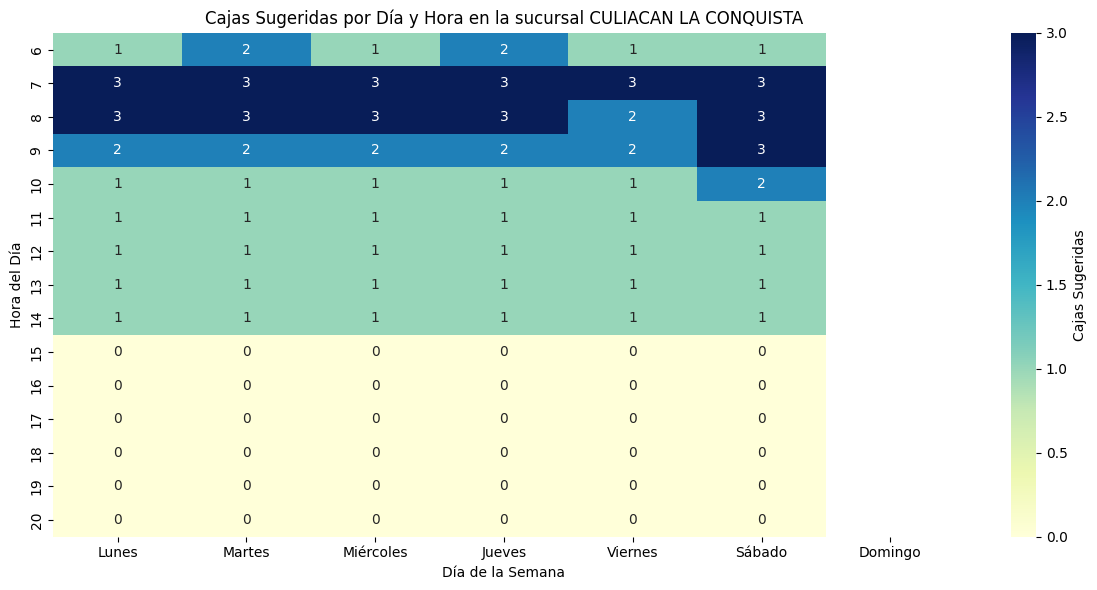

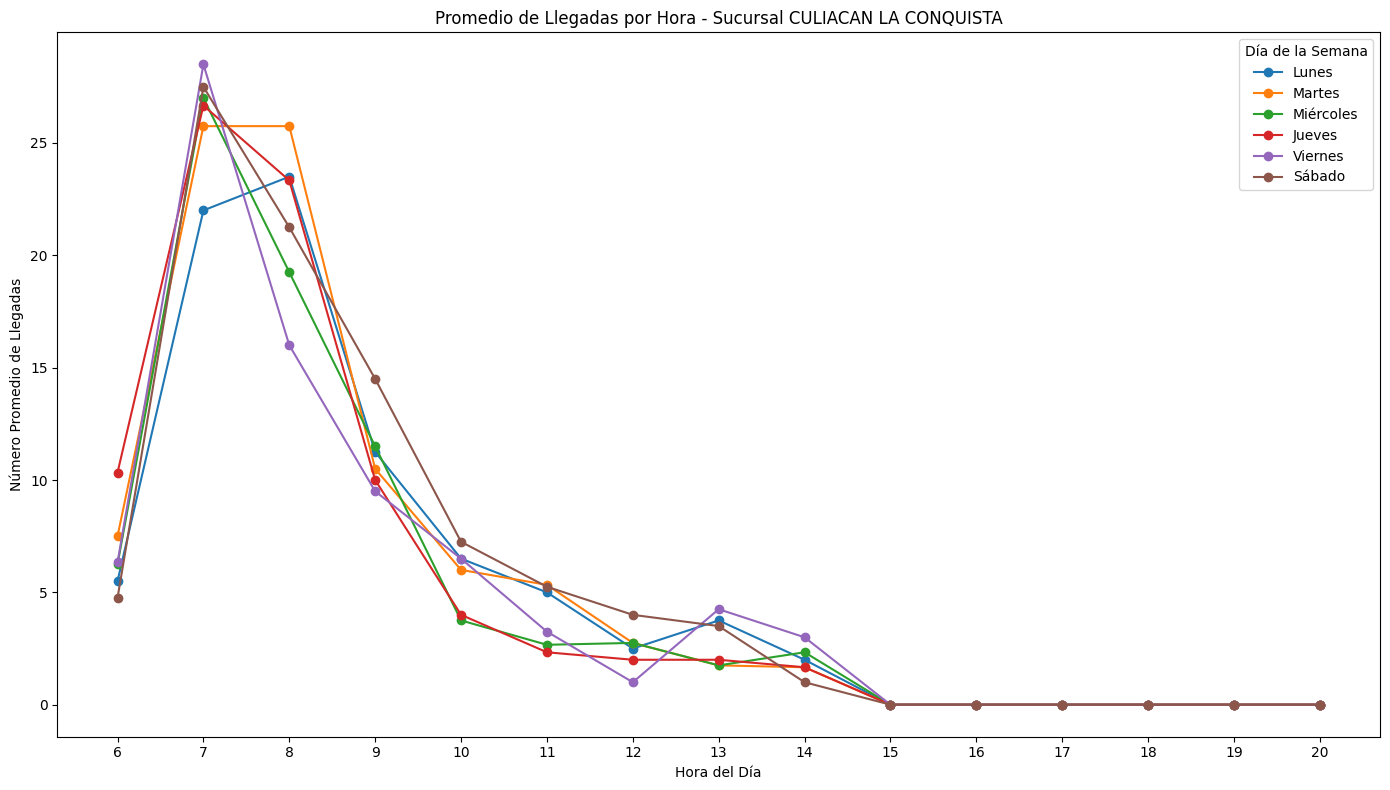

Archivo guardado como: resultado_cajas_sucursal_CULIACAN LA CONQUISTA.xlsx


In [29]:
resultado = analisis_cajas2("Muestra Proyecto Socios Formadores.xlsx", sucursal="CULIACAN LA CONQUISTA",max_cajas=3)

<ipython-input-26-24ffb3781dd5>:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (m√°x 10)'].mean().reset_index()


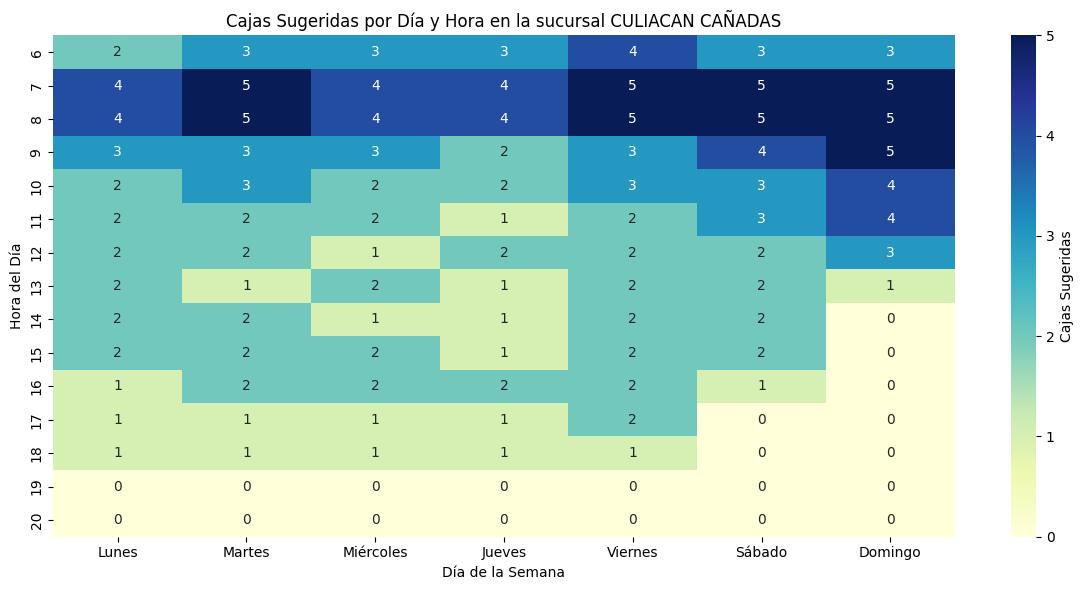

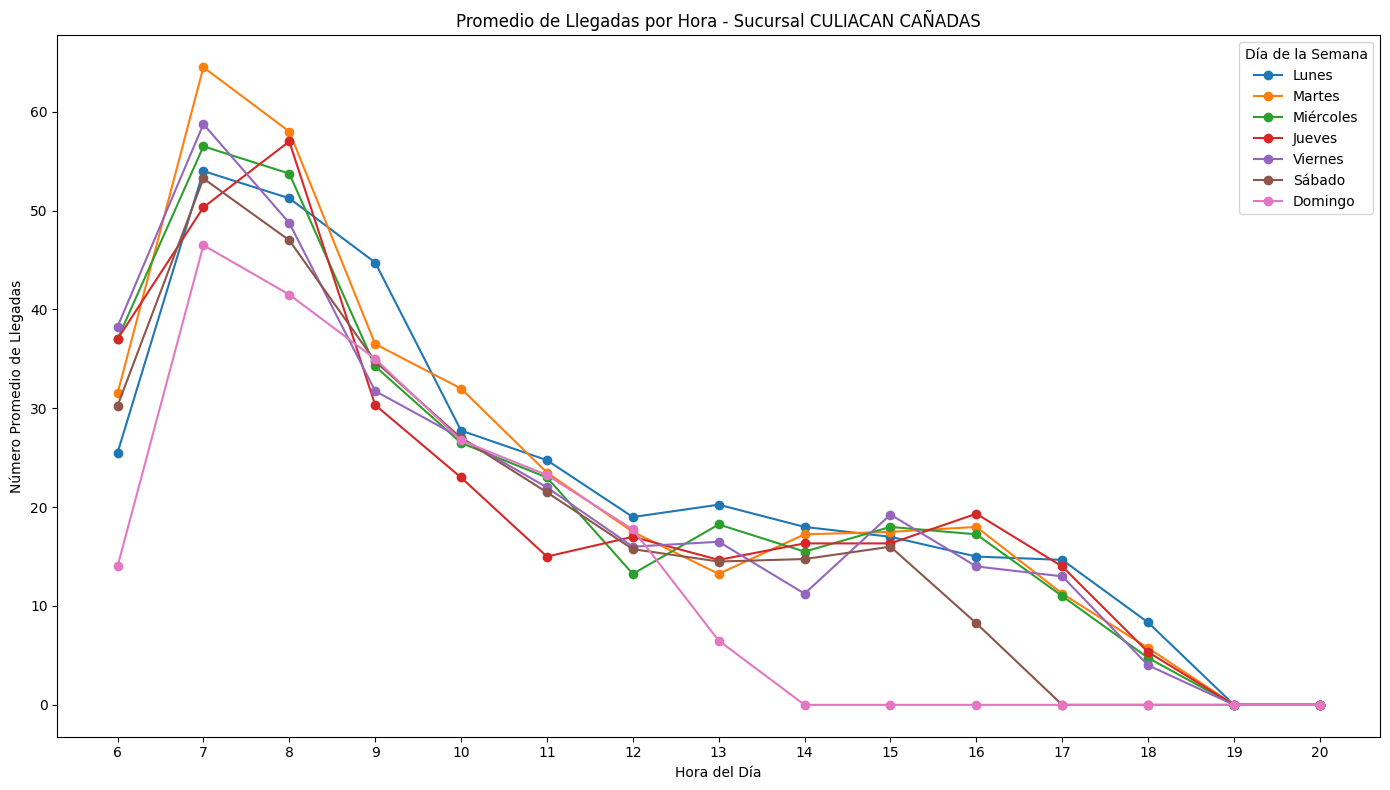

Archivo guardado como: resultado_cajas_sucursal_CULIACAN CA√ëADAS.xlsx


In [30]:
resultado = analisis_cajas2("Muestra Proyecto Socios Formadores.xlsx", sucursal="CULIACAN CA√ëADAS",max_cajas=5)

<ipython-input-26-24ffb3781dd5>:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot = df_resultado_horario.groupby(['Hora', 'DiaSemana'])['Cajas Sugeridas (m√°x 10)'].mean().reset_index()


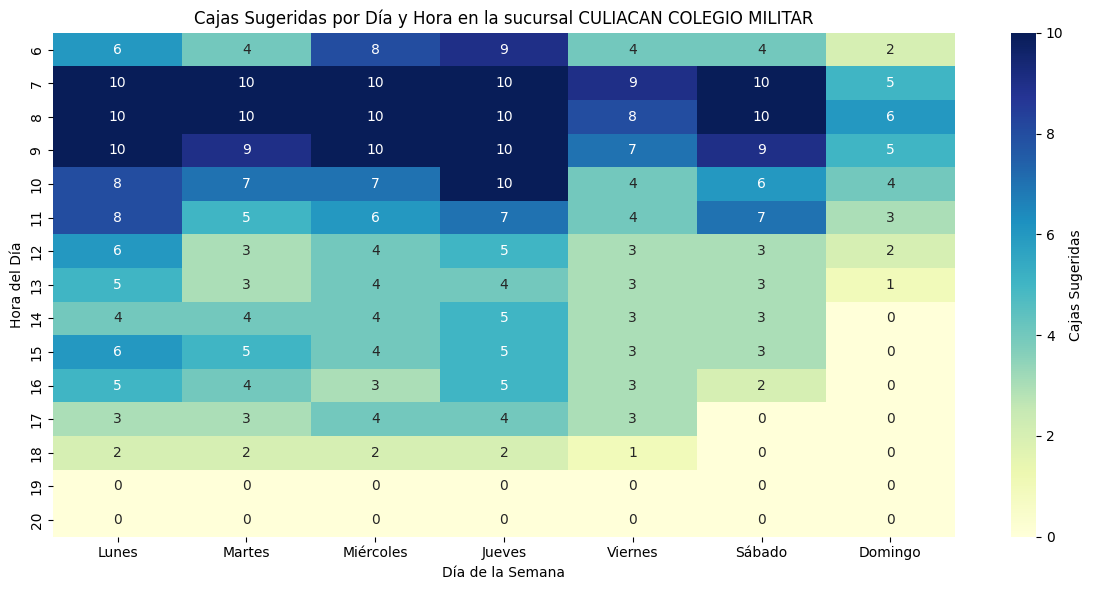

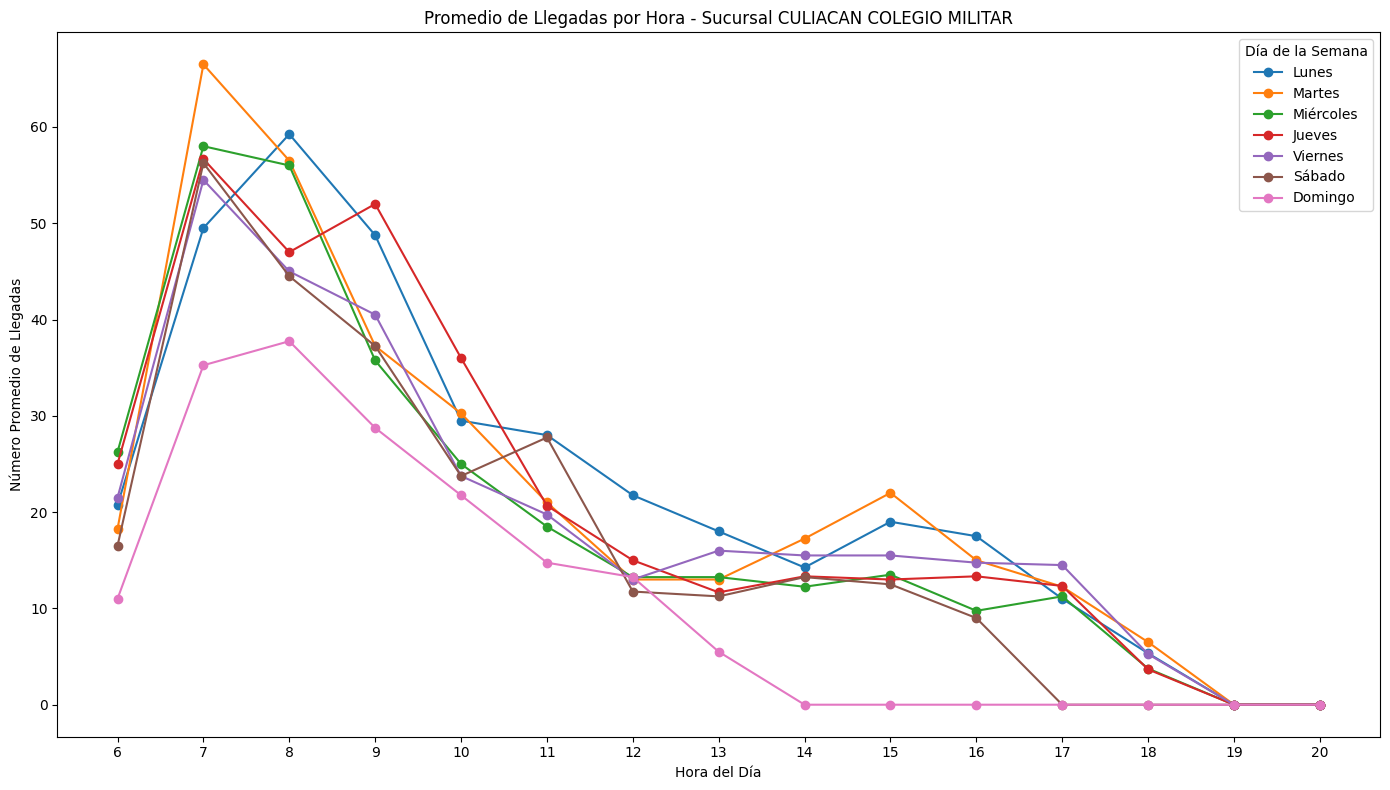

Archivo guardado como: resultado_cajas_sucursal_CULIACAN COLEGIO MILITAR.xlsx


In [31]:
resultado = analisis_cajas2("Muestra Proyecto Socios Formadores.xlsx", sucursal="CULIACAN COLEGIO MILITAR",max_cajas=10)

In [57]:
from scipy.stats import kruskal,f_oneway

def prueba_dia_semana_impacto(df_resultado_horario):
    print("\nüîç Prueba Kruskal-Wallis: ¬øel d√≠a de la semana afecta las llegadas por hora?\n")

    # Agrupar datos por d√≠a de la semana
    grupos = []
    dias = df_resultado_horario['DiaSemana'].unique()

    for dia in dias:
        data = df_resultado_horario[df_resultado_horario['DiaSemana'] == dia]['Llegadas'].values
        if len(data) > 0:
            grupos.append(data)

    # Ejecutar la prueba Kruskal-Wallis
    estadistico, p_valor = f_oneway(*grupos)
    print(f'Estad√≠stico H = {estadistico:.3f}')
    print(f'p-valor = {p_valor:.4f}')

    if p_valor < 0.05:
        print("‚úÖ Conclusi√≥n: El d√≠a de la semana S√ç afecta significativamente las llegadas.")
    else:
        print("‚ùå Conclusi√≥n: No se encontr√≥ una diferencia estad√≠sticamente significativa entre d√≠as.")


In [60]:
df=pd.read_excel("/content/resultado_cajas_sucursal_COYOACAN.xlsx")

In [61]:
prueba_dia_semana_impacto(df)


üîç Prueba Kruskal-Wallis: ¬øel d√≠a de la semana afecta las llegadas por hora?

Estad√≠stico H = 0.450
p-valor = 0.8435
‚ùå Conclusi√≥n: No se encontr√≥ una diferencia estad√≠sticamente significativa entre d√≠as.
